Dataset:

#!/bin/bash
curl -L -o ~/Downloads/massachusetts-buildings-dataset.zip\ https://www.kaggle.com/api/v1/datasets/download/balraj98/massachusetts-buildings-dataset

Image shape: (1500, 1500)


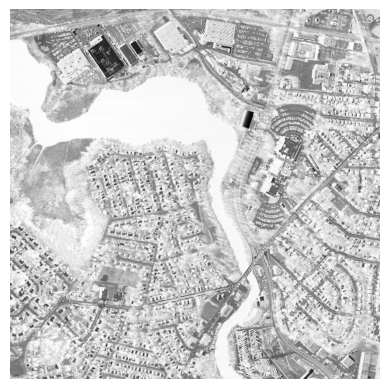

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import cv2
import os
from Vaizdas import Vaizdas
from IoU import IoU

dataset_path = "./massachusetts-buildings-dataset"
test_image_path = f"{dataset_path}/png/train/22678915_15.png"
test_image_mask = f"{dataset_path}/png/train_labels/22678915_15.png"
test_mask = cv2.imread(test_image_mask, cv2.IMREAD_GRAYSCALE)
test_image = Vaizdas(test_image_path)
test_image.show(test_image.gray, cmap="Grays")
result_history = []

Image shape: (1500, 1500)


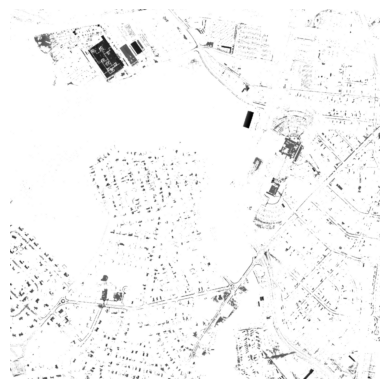

In [2]:
def thresholdSegment(image: Vaizdas) -> Vaizdas:
    threshold = image.gray < 160
    image.rgb[threshold] = 0
    blurred = cv2.GaussianBlur(image.gray, (5, 5), 0)

    image.set_mask(blurred)
    return image

temp = thresholdSegment(test_image)
temp.show(temp.mask, cmap="Grays")

Image shape: (1500, 1500)


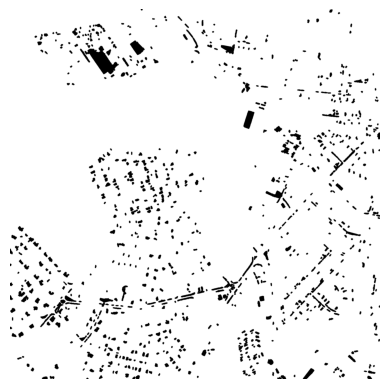

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [3]:
def mserSegment(image: Vaizdas) -> Vaizdas:
    
    mser = cv2.MSER_create(
    delta=5,              # it compares (sizei−sizei−delta)/sizei−delta
    min_area=10,           # prune the area which smaller than minArea 
    max_area=1500,        # prune the area which bigger than maxArea 
    max_variation=0.25,    # prune the area have similar size to its children 
    )

    regions, _ = mser.detectRegions(image.gray)

    mask = np.zeros_like(image.gray, dtype=np.uint8)

    cv2.drawContours(image=mask, 
                    contours=regions,
                    contourIdx=-1,
                    color=(255),
                    thickness=3)

    image.set_mask(mask)

    return image

temp = mserSegment(test_image)
temp.show(temp.mask, cmap="Grays")
print(temp.mask)

In [8]:
test_images = os.listdir(f'{dataset_path}/png/train')
vaizdai = [Vaizdas(f"{dataset_path}/png/train/{entry}") for entry in test_images]
true_masks = [cv2.imread(f"{dataset_path}/png/train_labels/{entry}", cv2.IMREAD_GRAYSCALE) for entry in test_images]


Image shape: (1500, 1500, 3)


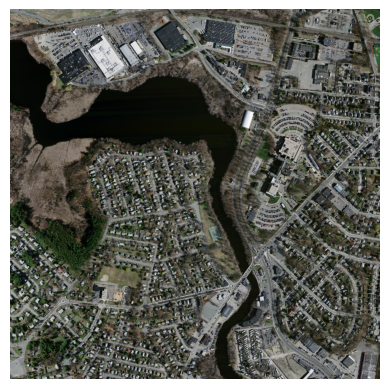

None


In [5]:
test = vaizdai[0]
test.show(test.mask, cmap="Grays")
print(test.mask)

In [9]:
vaizdai = [mserSegment(v) for v in vaizdai]

In [6]:
vaizdai = [thresholdSegment(v) for v in vaizdai]

Result for run nr. 0: 0.17326085573920413
Image shape: (1500, 1500)


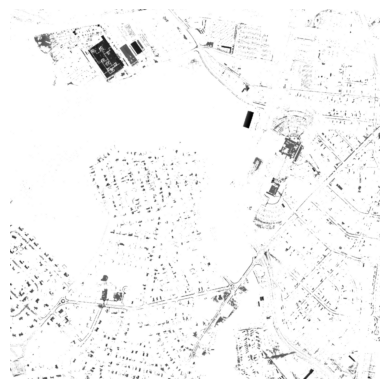

Image shape: (1500, 1500)


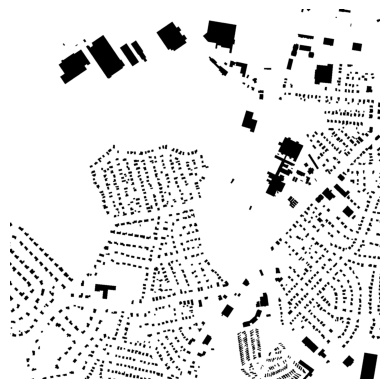

In [7]:
results = []
for img, mask in zip(vaizdai, true_masks):
    iou = IoU(mask, img.mask)
    results.append(iou.evaluate())

result_history.append(np.average(results))
for i, h in enumerate(result_history):
    print(f"Result for run nr. {i}: {h}")

vaizdai[0].show(vaizdai[0].mask, cmap="Grays")
vaizdai[0].show(true_masks[0], cmap="Grays")